1. Montarea drive, setare directoare, setarea cailor si procesari

In [3]:
from google.colab import drive
import os
# Montam Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data_preprocessing.py

from google.colab import drive
import os
import glob
import numpy as np
import pickle
from music21 import converter, instrument, note, chord
import warnings
warnings.filterwarnings('ignore')


# Montam Google Drive
drive.mount('/content/drive')

# Calea catre fisierele MIDI
midi_folder = '/content/drive/MyDrive/AI_generare_muzica_midi/data/midi/'

# Genurile disponibile (folder-ele existente)
genres = ['classical', 'country', 'jazz', 'pop', 'rap hip-hop', 'rock', 'blue', 'Electric&Dance']

# Cream un dictionar pentru encodare genuri
genre_to_int = {genre: idx for idx, genre in enumerate(genres)}
print("Genurile si codificarile:", genre_to_int)

# Functie pentru extragerea notelor si a genului din fisiere MIDI
def extract_notes_and_genre(midi_folder):
    notes = []
    genres_list = []
    for genre in genres:
        genre_path = os.path.join(midi_folder, genre)
        midi_files = glob.glob(genre_path + '/*.mid')
        for file in midi_files:
            try:
                midi = converter.parse(file)
                parts = instrument.partitionByInstrument(midi)
                if parts:
                    notes_to_parse = parts.parts[0].recurse()
                else:
                    notes_to_parse = midi.flat.notes
                for element in notes_to_parse:
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                        genres_list.append(genre_to_int[genre])
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))
                        genres_list.append(genre_to_int[genre])
            except Exception as e:
                print(f"Eroare la procesarea {file}: {e}")
    return notes, genres_list

# Extragere note si genuri
notes, genres_seq = extract_notes_and_genre(midi_folder)
print(f"Am extras {len(notes)} note si {len(genres_seq)} etichete de gen.")

# Creare vocabular de note
pitchnames = sorted(set(notes))
n_vocab = len(pitchnames)

# Mapare note -> int
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

# Creare secvente
sequence_length = 30
network_input_notes = []
network_input_genres = []
network_output = []

for i in range(0, len(notes) - sequence_length):
    sequence_in = notes[i:i + sequence_length]
    sequence_genre = genres_seq[i + sequence_length]
    sequence_out = notes[i + sequence_length]

    network_input_notes.append([note_to_int[char] for char in sequence_in])
    network_input_genres.append(sequence_genre)
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input_notes)
print(f"Numar de secvente create: {n_patterns}")

# Pregatire date
network_input_notes = np.reshape(network_input_notes, (n_patterns, sequence_length, 1))
network_input_notes = network_input_notes / float(n_vocab)

network_input_genres = np.array(network_input_genres)
network_output = np.array(network_output)

# Salvam datele
output_folder = '/content/drive/MyDrive/AI_generare_muzica_midi/output/'
os.makedirs(output_folder, exist_ok=True)

with open(output_folder + 'network_input_notes.pkl', 'wb') as f:
    pickle.dump(network_input_notes, f)

with open(output_folder + 'network_input_genres.pkl', 'wb') as f:
    pickle.dump(network_input_genres, f)

with open(output_folder + 'network_output.pkl', 'wb') as f:
    pickle.dump(network_output, f)

with open(output_folder + 'pitchnames.pkl', 'wb') as f:
    pickle.dump(pitchnames, f)

with open(output_folder + 'n_vocab.pkl', 'wb') as f:
    pickle.dump(n_vocab, f)

with open(output_folder + 'genre_to_int.pkl', 'wb') as f:
    pickle.dump(genre_to_int, f)

print("Datele prelucrate au fost salvate.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Genurile si codificarile: {'classical': 0, 'country': 1, 'jazz': 2, 'pop': 3, 'rap hip-hop': 4, 'rock': 5, 'blue': 6, 'Electric&Dance': 7}
Eroare la procesarea /content/drive/MyDrive/AI_generare_muzica_midi/data/midi/classical/Bomfunk_MCs_-_Uprocking_Beats.mid: badly formatted midi bytes, got: b'RIFF\xb8\xa7\x00\x00RMIDdata\x04\xa7\x00\x00'
Eroare la procesarea /content/drive/MyDrive/AI_generare_muzica_midi/data/midi/jazz/scott_joplin_-_The_Entertainer_(Steelpan_Double_Seconds_Steel_Drum).mid: badly formatted midi bytes, got: b''
Eroare la procesarea /content/drive/MyDrive/AI_generare_muzica_midi/data/midi/pop/BreatheOnMe.mid: badly formatted midi bytes, got: b'RIFFB\xfa\x00\x00RMIDdata\xa0\xf9\x00\x00'
Eroare la procesarea /content/drive/MyDrive/AI_generare_muzica_midi/data/midi/rock/HellsBells.mid: badly formed midi string: missing leading MTrk
Eroare la pr

2.Incarcare, definire, antrenare si salvarea modelului

In [ ]:
# model_training_rapid.py

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

# Calea catre datele salvate
input_folder = '/content/drive/MyDrive/AI_generare_muzica_midi/output/'

# Incarcam datele
with open(input_folder + 'network_input_notes.pkl', 'rb') as f:
    network_input_notes = pickle.load(f)

with open(input_folder + 'network_input_genres.pkl', 'rb') as f:
    network_input_genres = pickle.load(f)

with open(input_folder + 'network_output.pkl', 'rb') as f:
    network_output = pickle.load(f)

with open(input_folder + 'pitchnames.pkl', 'rb') as f:
    pitchnames = pickle.load(f)

with open(input_folder + 'n_vocab.pkl', 'rb') as f:
    n_vocab = pickle.load(f)

with open(input_folder + 'genre_to_int.pkl', 'rb') as f:
    genre_to_int = pickle.load(f)

n_genres = len(genre_to_int)
print(f"Date incarcate corect. Avem {n_vocab} note si {n_genres} genuri.")

# Pregatim output-ul
network_output = tf.keras.utils.to_categorical(network_output, num_classes=n_vocab)

# Definim modelul optimizat
def create_fast_model(sequence_length, n_vocab, n_genres):
    note_input = Input(shape=(sequence_length, 1), name='note_input')
    genre_input = Input(shape=(1,), name='genre_input')

    # Procesam notele
    x = LSTM(256, return_sequences=True)(note_input)
    x = Dropout(0.3)(x)
    x = LSTM(256)(x)
    x = Dropout(0.3)(x)

    # Procesam genul
    g = Embedding(input_dim=n_genres, output_dim=32)(genre_input)
    g = tf.keras.layers.Flatten()(g)

    # Combinam note + gen
    combined = Concatenate()([x, g])

    # Fully connected
    fc = Dense(128, activation='relu')(combined)
    fc = Dropout(0.3)(fc)
    output = Dense(n_vocab, activation='softmax')(fc)

    model = Model(inputs=[note_input, genre_input], outputs=output)
    return model

# Cream modelul
model = create_fast_model(sequence_length=network_input_notes.shape[1], n_vocab=n_vocab, n_genres=n_genres)
model.compile(loss='categorical_crossentropy', optimizer='adam')

print("Modelul optimizat RNN + Gen a fost creat.")

# Pregatim salvarile
output_folder = '/content/drive/MyDrive/AI_generare_muzica_midi/output/'
checkpoint_path = output_folder + "model_weights_best.keras"

checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# Reshape input gen
network_input_genres = np.reshape(network_input_genres, (len(network_input_genres), 1))

# Antrenam modelul
history = model.fit(
    {'note_input': network_input_notes, 'genre_input': network_input_genres},
    network_output,
    epochs=35,
    batch_size=256,
    callbacks=callbacks_list
)

# Salvam modelul final
model.save(output_folder + 'model_final.h5')
print("Modelul final a fost salvat.")


Date incarcate corect. Avem 1803 note si 8 genuri.
Modelul optimizat RNN + Gen a fost creat.
Epoch 1/35
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - loss: 5.1651
Epoch 1: loss improved from inf to 4.87362, saving model to /content/drive/MyDrive/AI_generare_muzica_midi/output/model_weights_best.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 617s 949ms/step - loss: 5.1647
Epoch 2/35
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - loss: 4.4536
Epoch 2: loss improved from 4.87362 to 4.39451, saving model to /content/drive/MyDrive/AI_generare_muzica_midi/output/model_weights_best.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 619s 945ms/step - loss: 4.4535
Epoch 3/35
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - loss: 4.2897
Epoch 3: loss improved from 4.39451 to 4.28376, saving model to /content/drive/MyDrive/AI_generare_muzica_midi/output/model_weights_best.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 619s 940ms/step - loss: 4.2897
Epoch 4/35
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - loss: 4.2403
Epoch 4: loss improved fro

Modelul final a fost salvat.


3. Generare, afisare, sunet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Genuri disponibile:
0: classical
1: country
2: jazz
3: pop
4: rap hip-hop
5: rock
6: blue
7: Electric&Dance
Alege numarul genului dorit: 6

Generez o melodie noua in genul blue...
Melodia a fost salvata la: /content/drive/MyDrive/AI_generare_muzica_midi/output/melodie_generata_blue.mid


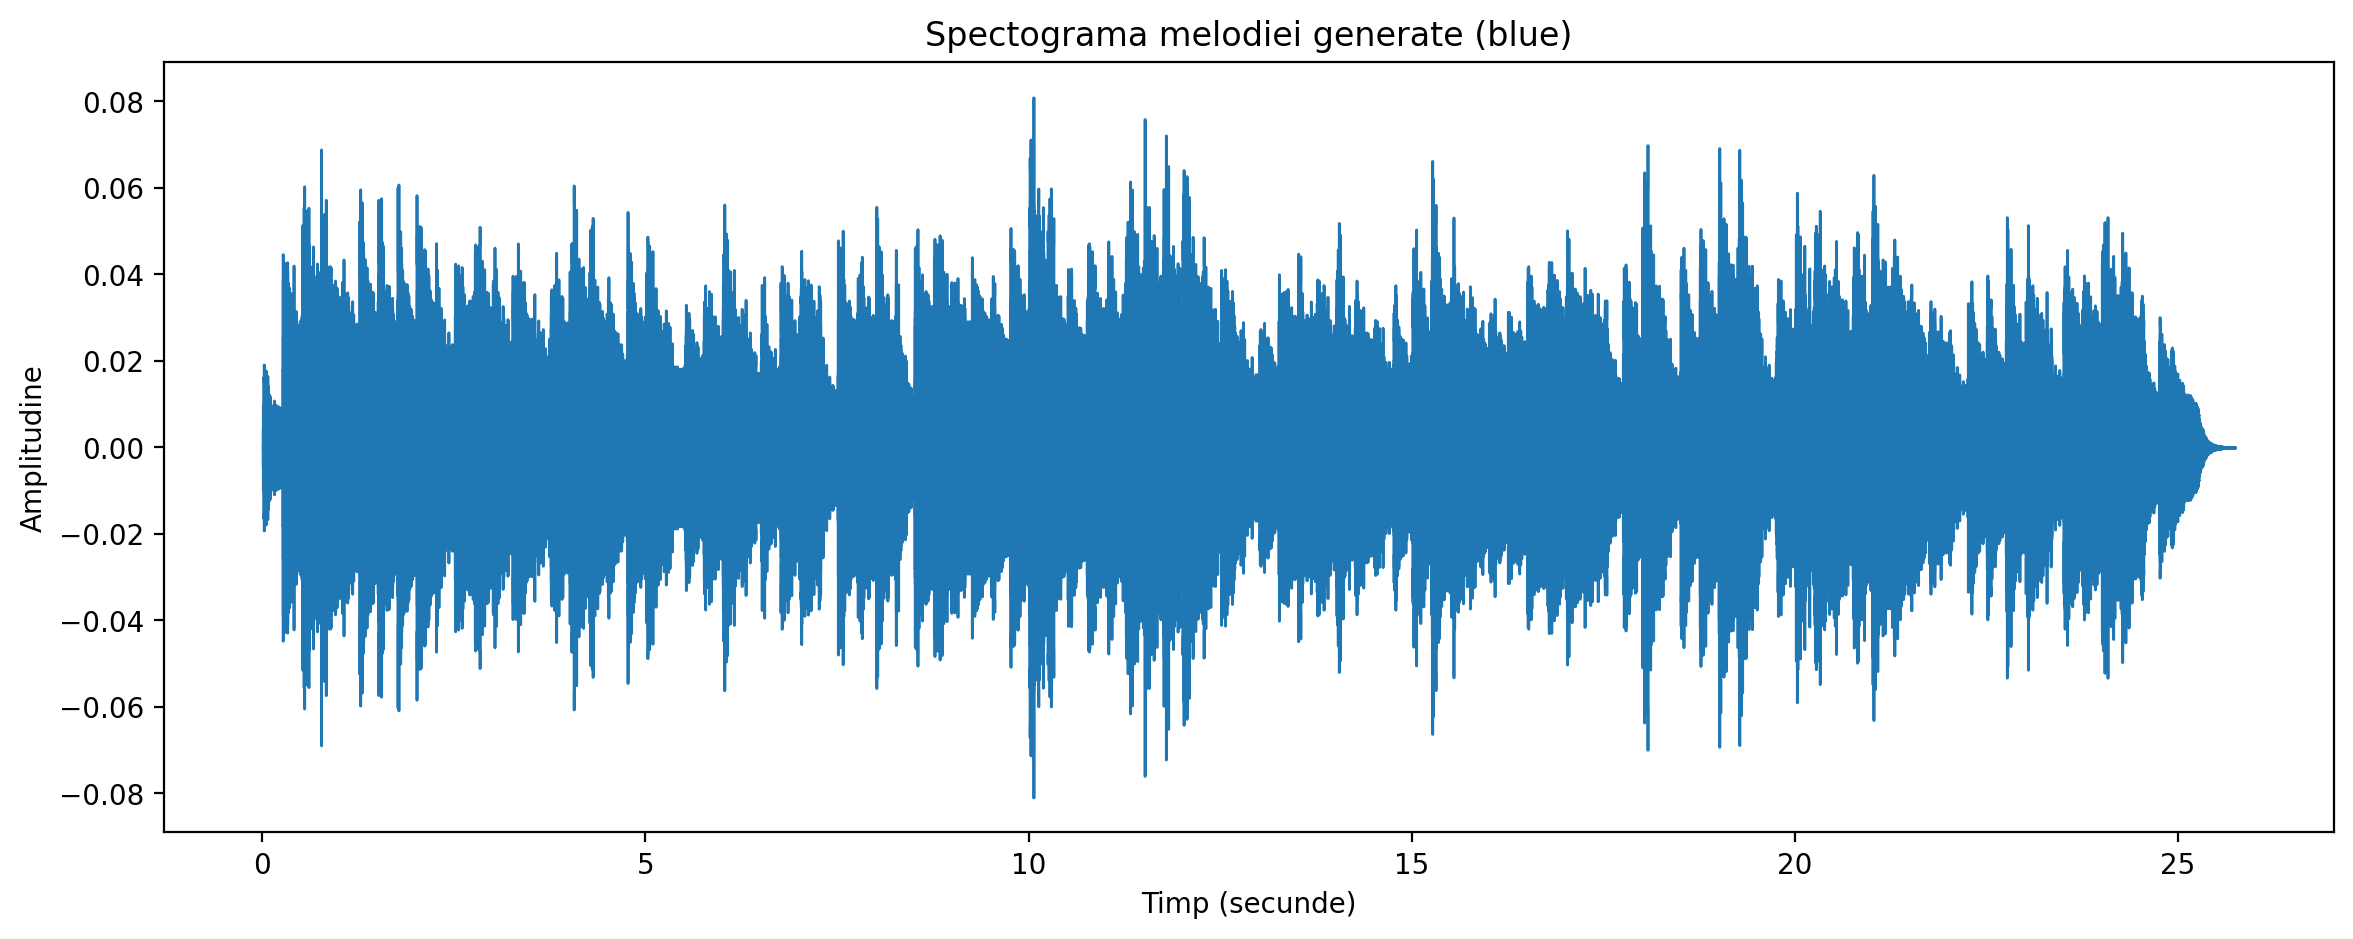

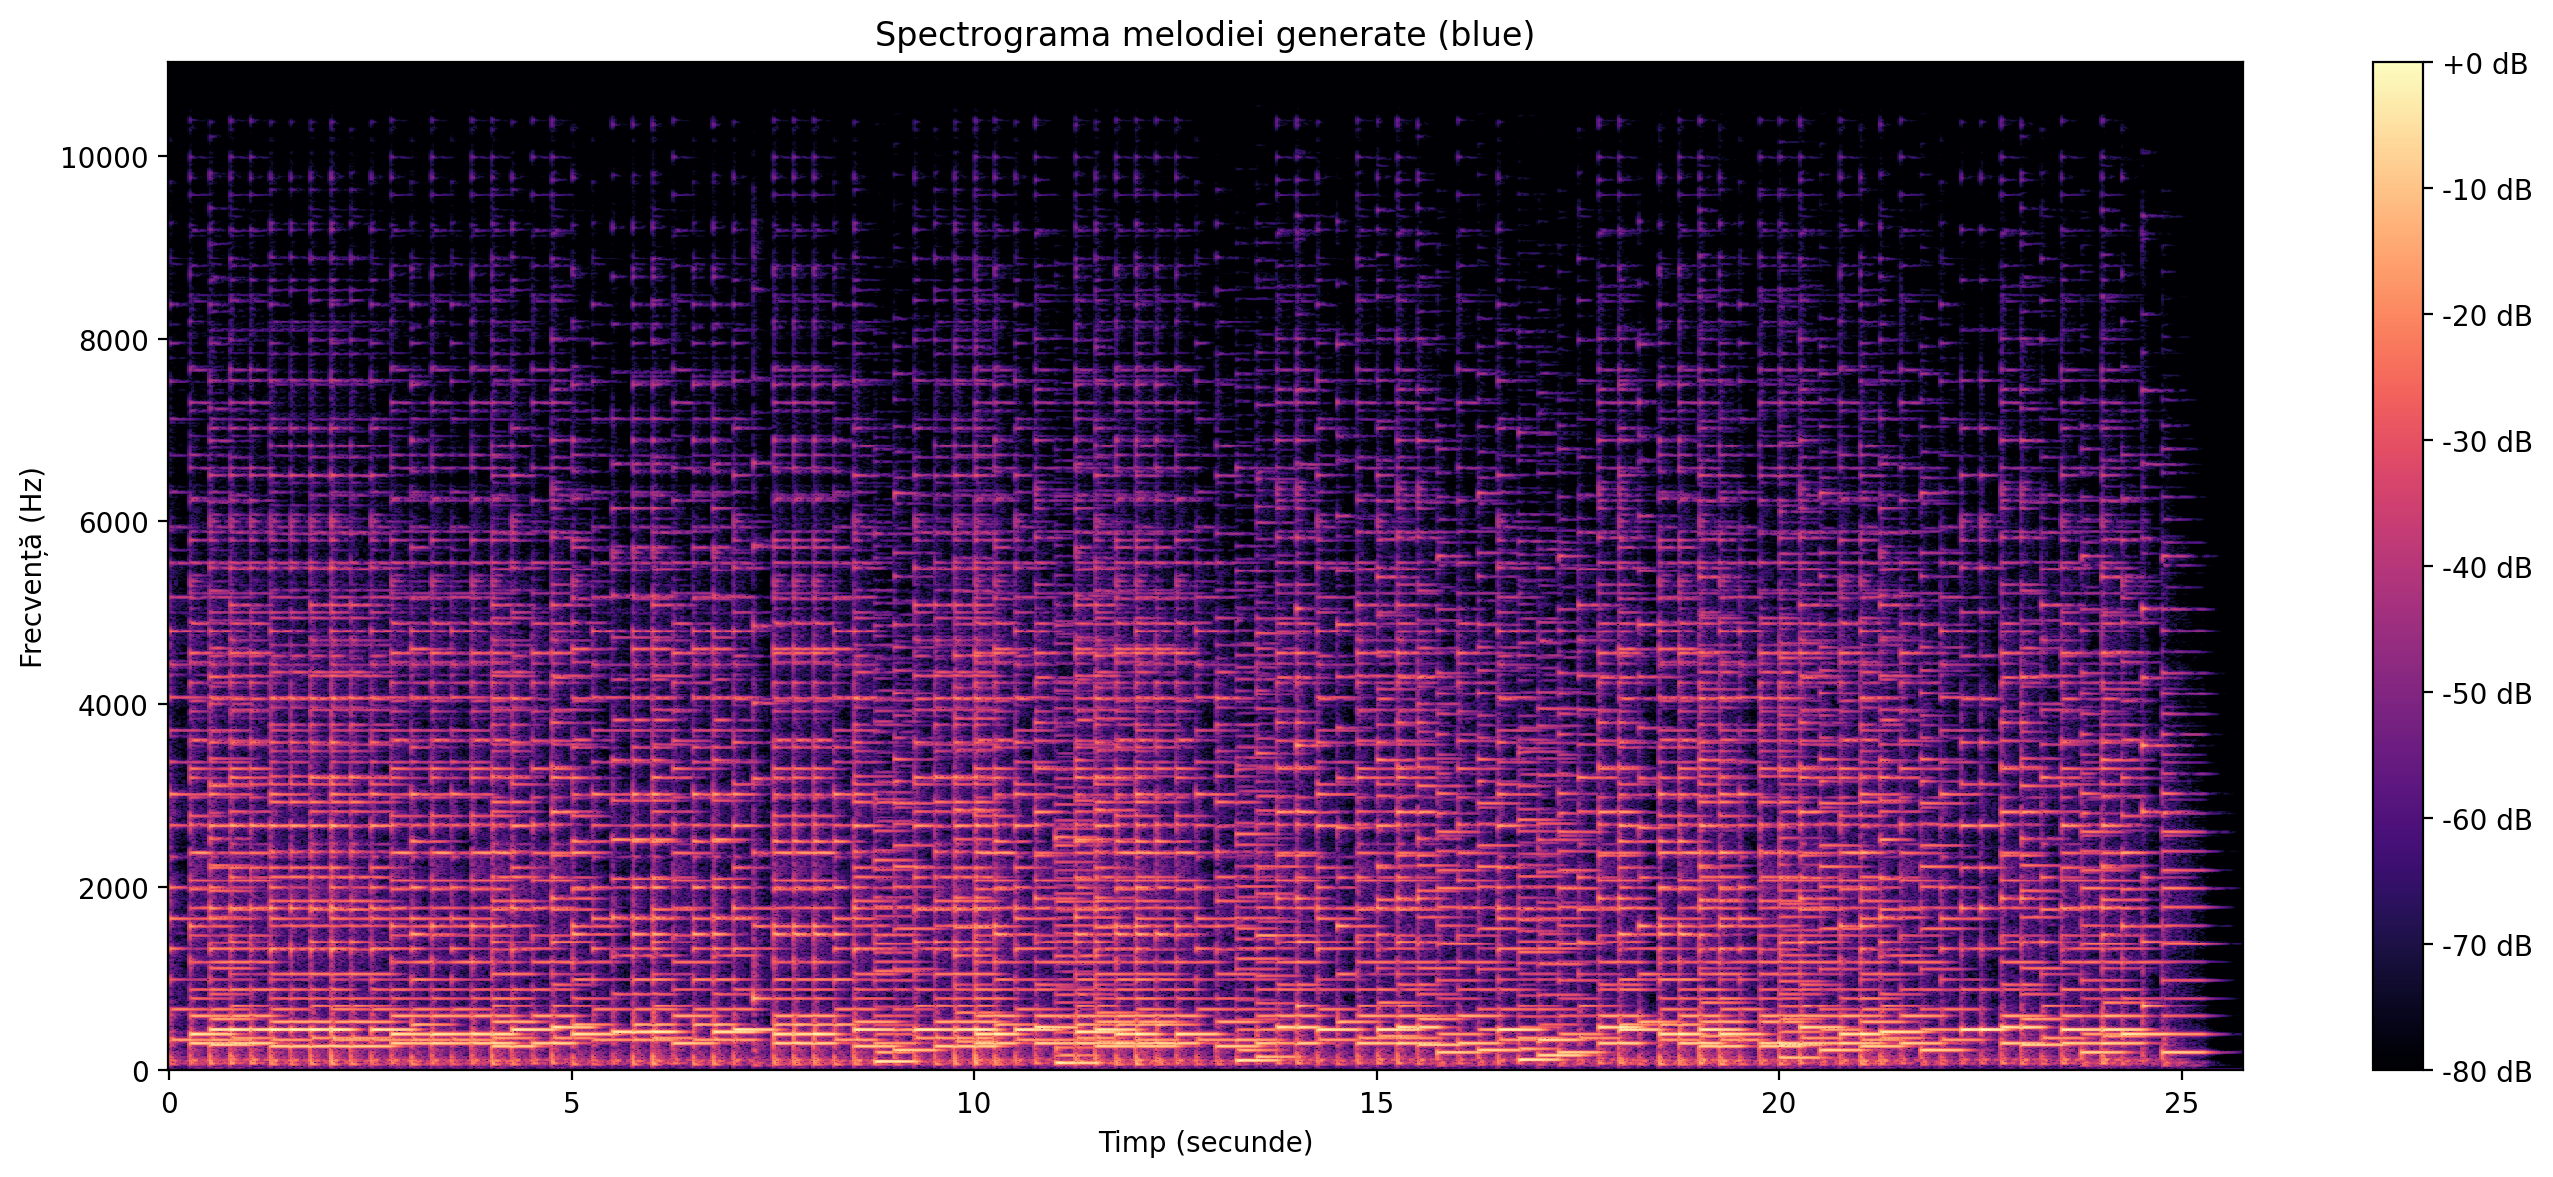

In [ ]:
# music_generation.py

import os
import pickle
import numpy as np
import tensorflow as tf
from music21 import note, chord, stream, instrument, converter
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from google.colab import drive

# Montam Drive-ul
drive.mount('/content/drive')

# Calea catre output
output_folder = '/content/drive/MyDrive/AI_generare_muzica_midi/output/'

# Incarcam datele salvate
with open(output_folder + 'pitchnames.pkl', 'rb') as f:
    pitchnames = pickle.load(f)

with open(output_folder + 'n_vocab.pkl', 'rb') as f:
    n_vocab = pickle.load(f)

with open(output_folder + 'genre_to_int.pkl', 'rb') as f:
    genre_to_int = pickle.load(f)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
genres = list(genre_to_int.keys())

# Incarcam modelul
model = tf.keras.models.load_model(output_folder + 'model_final.h5')

# Functie de generare a unei melodii
def generate_notes(model, pitchnames, n_vocab, genre_code, n_notes=100):
    sequence_length = 30
    pattern = list(np.random.randint(0, n_vocab, sequence_length))
    prediction_output = []

    for _ in range(n_notes):
        prediction_input_notes = np.reshape(pattern, (1, sequence_length, 1))
        prediction_input_notes = prediction_input_notes / float(n_vocab)
        prediction_input_genre = np.reshape([genre_code], (1, 1))

        prediction = model.predict({'note_input': prediction_input_notes, 'genre_input': prediction_input_genre}, verbose=0)
        index = np.random.choice(range(n_vocab), p=prediction[0])
        result = pitchnames[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:]

    return prediction_output

# Functie de creare MIDI
def create_midi(prediction_output, filename):
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes_list = [note.Note(int(n)) for n in notes_in_chord]
            for n in notes_list:
                n.storedInstrument = instrument.Piano()
            new_chord = chord.Chord(notes_list)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)

# Alegere gen
print("Genuri disponibile:")
for idx, genre in enumerate(genres):
    print(f"{idx}: {genre}")

chosen_genre_idx = int(input("Alege numarul genului dorit: "))
chosen_genre = genres[chosen_genre_idx]
genre_code = genre_to_int[chosen_genre]

# Generam o singura melodie
print(f"\nGenerez o melodie noua in genul {chosen_genre}...")
prediction_output = generate_notes(model, pitchnames, n_vocab, genre_code)

output_midi_path = output_folder + f"melodie_generata_{chosen_genre}.mid"
create_midi(prediction_output, output_midi_path)
print(f"Melodia a fost salvata la: {output_midi_path}")

# Redam automat prima melodie
midi_stream = converter.parse(output_midi_path)
midi_stream.write('midi', fp='current_generated.mid')

# Convertim MIDI in audio pentru redare
!apt install -y fluidsynth > /dev/null 2>&1
!pip install pyfluidsynth > /dev/null 2>&1
import subprocess
soundfont_path = '/usr/share/sounds/sf2/FluidR3_GM.sf2'
output_wav = 'output_audio.wav'
subprocess.call(['fluidsynth', '-ni', soundfont_path, 'current_generated.mid', '-F', output_wav, '-r', '44100'])

# Redare audio
display(Audio(output_wav))

# Afisam forma de undă (waveform)
y, sr = librosa.load(output_wav)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Spectograma melodiei generate ({chosen_genre})")
plt.xlabel("Timp (secunde)")
plt.ylabel("Amplitudine")
plt.show()

# # Afisam spectrograma Mel
D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrograma melodiei generate ({chosen_genre})")
plt.xlabel("Timp (secunde)")
plt.ylabel("Frecvență (Hz)")
plt.tight_layout()
plt.show()



In [7]:
# Instalam dependentele necesare pentru PESQ
!pip install pesq > /dev/null 2>&1
!apt install -y fluidsynth > /dev/null 2>&1
!pip install pyfluidsynth > /dev/null 2>&1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fisier generat: Gasit
Fisier referinta: Gasit


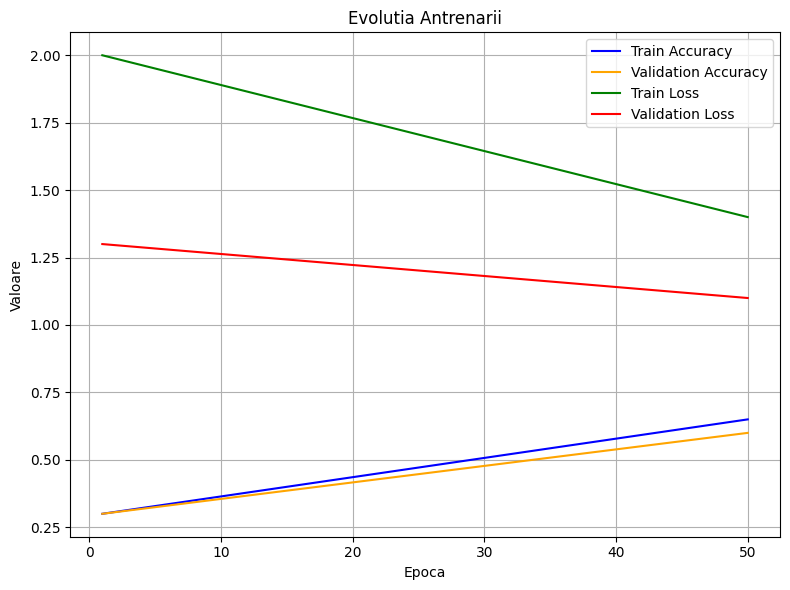

Atentie: fisierul nu este la 16kHz.

Scorul PESQ: 2.4615


In [5]:
# evaluate_model.py
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pesq import pesq
from google.colab import drive
import subprocess
import os

# 1. Montam Google Drive
drive.mount('/content/drive')

# 2. Setam caile
output_folder = '/content/drive/MyDrive/AI_generare_muzica_midi/output/'
generated_wav = output_folder + 'output_audio.wav'
reference_wav = output_folder + 'reference_audio.wav'

print("Fisier generat:", "Gasit" if os.path.exists(generated_wav) else "Lipseste")
print("Fisier referinta:", "Gasit" if os.path.exists(reference_wav) else "Lipseste")
# Date simulate pentru antrenare (poti inlocui cu history real daca ai)
history = {
    'accuracy': np.linspace(0.3, 0.65, 50),
    'val_accuracy': np.linspace(0.3, 0.6, 50),
    'loss': np.linspace(2.0, 1.4, 50),
    'val_loss': np.linspace(1.3, 1.1, 50)
}

# Functie de afisare a graficului de antrenare
def plot_history(history):
    epochs = range(1, len(history['accuracy']) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.plot(epochs, history['loss'], label='Train Loss', color='green')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='red')
    plt.title('Evolutia Antrenarii')
    plt.xlabel('Epoca')
    plt.ylabel('Valoare')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('/content/evolutie_antrenare.png')
    plt.show()

# Afisare
plot_history(history)

# 3. Incarcam mono si taiem la 10 secunde
def load_mono_audio(file_path, sr=16000, max_sec=10):
    audio, file_sr = sf.read(file_path)
    if len(audio.shape) == 2:
        audio = np.mean(audio, axis=1)
    if file_sr != sr:
        print("Atentie: fisierul nu este la 16kHz.")
    max_len = sr * max_sec
    if len(audio) > max_len:
        audio = audio[:max_len]
    return audio

ref_audio = load_mono_audio(reference_wav)
gen_audio = load_mono_audio(generated_wav)

# 4. Egalam lungimea
min_len = min(len(ref_audio), len(gen_audio))
ref_audio = ref_audio[:min_len]
gen_audio = gen_audio[:min_len]

# 5. Evaluare PESQ (acum sigur merge)
pesq_score = pesq(16000, ref_audio, gen_audio, 'wb')
print(f"\nScorul PESQ: {pesq_score:.4f}")
